In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
%matplotlib inline 
import seaborn as sns
import pandas as pd
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn import linear_model,svm,ensemble,tree

# special matplotlib argument for improved plots
from matplotlib import rcParams

import samples
reload(samples)
import spectral
reload(spectral)
import audiolearning
reload(audiolearning)
import mytimer as mt
reload(mt)
print

In [2]:
import os
import sys
import csv
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [3]:
FFT_BINS = 60;
FWIN = 25;
TWIN = 1;
NPERSEG = 1024;
TSUB = 1; #NOTE: this will be used only for training. Will experiment with test format later.
NSUB = 10;
#Last day of 'training' data
MONTH = 6;
DAY = 2;

In [4]:
all_samples = samples.getAllSamples(Tsub=TSUB,Nsub=NSUB,READ_IN=False)

Imported 1507 Supersamples


In [5]:
class phi_sped_mfcc:
    LEN = 0;
    def __init__(self,fft_bins):
        #self.LEN = fft_bins;
        self.LEN = fft_bins+13;
        self.fft_bins = fft_bins;

    def get_phi(self,sample):
        '''
        Takes in a super_sample and returns a feature array. Breaks the super_sample
        down into samples. Each row of the returned value corresponds to a sample
        in the super sample.
        '''

        XSPED = spectral.getSupersampleSPED(sample,self.fft_bins,fwin=FWIN,twin = TWIN,nperseg = NPERSEG,spacing="log")
        XMFCC = spectral.getSampleMFCC(sample)
        return np.hstack((XMFCC,XSPED))
myPhi = phi_sped_mfcc(FFT_BINS)
extractor = audiolearning.Classifier(myPhi)

In [6]:
(X_compact,Y_compact) = extractor.extract_features(all_samples)
m, nsub, nfeat = np.shape(X_compact)
phi_X = np.reshape(X_compact,(m*nsub,nfeat))
Y_flat = np.repeat(Y_compact,nsub)    
allData = samples.DataPhi()
allData.X = X_compact
allData.Y = Y_compact
allData.X_flat = phi_X
allData.Y_flat = Y_flat

Running feature extraction...
0%...
9%...
19%...
29%...
39%...
49%...
59%...
69%...
79%...
89%...
99%...


In [7]:
spectral.getSignalMFCC(all_samples[50].getData()).shape

(13L,)

<Container object of 3 artists>

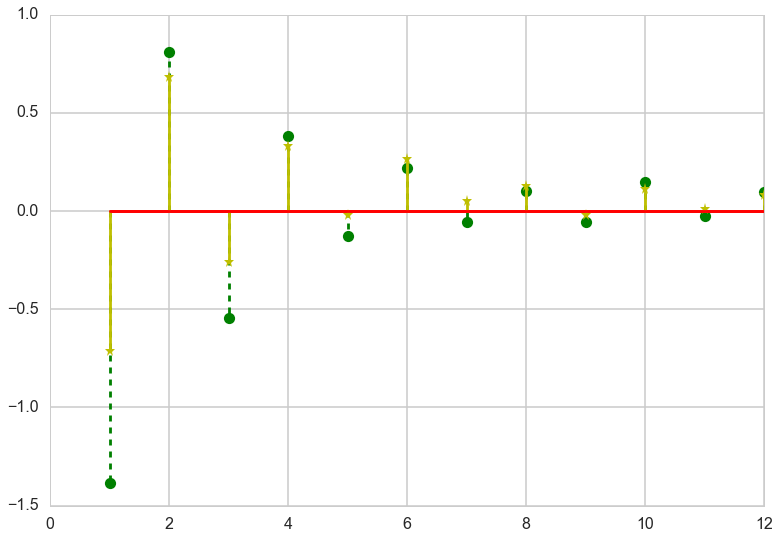

In [8]:
mfcc50  = spectral.getSignalMFCC(all_samples[50].getData())
mfcc15  = spectral.getSignalMFCC(all_samples[15].getData())
plt.stem(range(1,13),mfcc50[1:],markerfmt ='go',linefmt = 'g--' )
plt.stem(range(1,13),mfcc15[1:],markerfmt ='y*',linefmt='y')

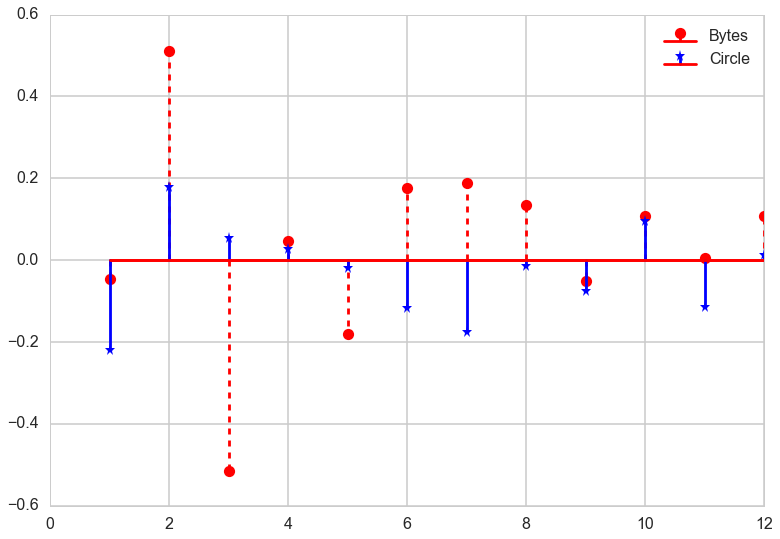

In [9]:
mfcc407 = spectral.getSignalMFCC(all_samples[407].getData())
mfcc500 = spectral.getSignalMFCC(all_samples[500].getData())
plt.stem(range(1,13),mfcc407[1:],markerfmt ='ro',linefmt = 'r--' )
plt.stem(range(1,13),mfcc500[1:],markerfmt ='b*',linefmt='b')
plt.legend(['Bytes','Circle'])

In [20]:
with open('Poster_Data.pkl','wb') as f:
    pickle.dump((X_train,Y_train),f)

In [19]:
with open('Poster_CLF_Data.pkl','rb') as f:
    (test,_,_) = pickle.load(f)

EOFError: 

In [11]:
svm_clf = audiolearning.Classifier(myPhi)
(X_train,Y_train,X_test,Y_test) = audiolearning.train_test_split_audio(X_compact,Y_compact)

In [12]:
svm_clf.trainSVMBatch(train_samples=None, X_train=X_train,Y_train=Y_train,C=5,gamma=0.001)

Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0000
Error for region 1: 0.0268
Error for region 2: 0.0000
Error for region 3: 0.0000
Error for region 4: 0.0000
Error for region 5: 0.0079
Error for region 6: 0.0000
---- Total Training Error: 0.0047


0.004739336492891044

In [13]:
(err,cm) = svm_clf.testClassifier(test_samples=None,X_test=X_test,Y_test=Y_test,get_conf_mat=True)

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.0909
Error for region 1: 0.1311
Error for region 2: 0.0175
Error for region 3: 0.0455
Error for region 4: 0.0161
Error for region 5: 0.2424
Error for region 6: 0.0159
---- Total Testing Error: 0.0819


In [14]:
np.set_printoptions(linewidth=150)
print np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)

[[ 0.9091  0.013   0.      0.013   0.      0.0649  0.    ]
 [ 0.0984  0.8689  0.      0.0164  0.      0.0164  0.    ]
 [ 0.      0.      0.9825  0.      0.0175  0.      0.    ]
 [ 0.      0.0455  0.      0.9545  0.      0.      0.    ]
 [ 0.      0.      0.0161  0.      0.9839  0.      0.    ]
 [ 0.1061  0.1061  0.0152  0.0152  0.      0.7576  0.    ]
 [ 0.      0.      0.      0.      0.0159  0.      0.9841]]


In [87]:
import datetime
temp = [x.date for x in all_samples]
cutoff = datetime.date(2016,5,30)
train_idx = [i for i,x in enumerate(temp) if x <= cutoff]
test_idx = [i for i,x in enumerate(temp) if x > cutoff]
X_train_compact = X_compact[train_idx,:,:]
Y_train_compact = Y_compact[train_idx]
X_gen_compact= X_compact[test_idx,:,:]
Y_gen_compact = Y_compact[test_idx]

In [88]:
(X_train,Y_train,X_test,Y_test) = audiolearning.train_test_split_audio(X_train_compact,Y_train_compact)

In [95]:
svm_gen_clf = audiolearning.Classifier(myPhi);
svm_gen_clf.trainSVMBatch(train_samples=None, X_train=X_train,Y_train=Y_train,C=5,gamma=0.001)


Finished Training Classifier with Training Error:---------------
Error for region 0: 0.0000
Error for region 1: 0.0000
Error for region 2: 0.0000
Error for region 3: 0.0000
Error for region 4: 0.0000
Error for region 5: 0.0104
Error for region 6: 0.0000
---- Total Training Error: 0.0013


0.001322751322751281

In [96]:
(_,cm) = svm_gen_clf.testClassifier(test_samples=None,X_test=X_gen_compact,Y_test=Y_gen_compact,get_conf_mat=True)

-----------------------------------------------------
-------------------Testing Error:-------------------
Error for region 0: 0.1500
Error for region 1: 0.1667
Error for region 2: 0.2459
Error for region 3: 0.1500
Error for region 4: 0.1167
Error for region 5: 0.4000
Error for region 6: 0.1818
---- Total Testing Error: 0.2014


In [97]:
print np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],4)

[[ 0.85    0.1167  0.      0.      0.      0.0333  0.    ]
 [ 0.0167  0.8333  0.0333  0.      0.0333  0.0833  0.    ]
 [ 0.      0.1311  0.7541  0.      0.0656  0.      0.0492]
 [ 0.      0.0833  0.      0.85    0.      0.0667  0.    ]
 [ 0.      0.05    0.0667  0.      0.8833  0.      0.    ]
 [ 0.0333  0.2167  0.      0.0167  0.      0.6     0.1333]
 [ 0.      0.0909  0.      0.0152  0.0758  0.      0.8182]]


In [ ]:
def tsne_viz(
        mat,
        rownames,
        colors=None,
        output_filename=None,
        figheight=40,
        figwidth=50):     
    """2d plot of `mat` using t-SNE, with the points labeled by `rownames`, 
    aligned with `colors` (defaults to all black).
    
    Parameters
    ----------    
    mat : 2d np.array
        The matrix to visualize.
        
    rownames : list of str
        Names of the points to visualize.
                
    colors : list of colornames or None (default: None)
        Optional list of colors for rownames. The color names just need to 
        be interpretable by matplotlib. If they are supplied, they need to 
        have the same length as rownames, or indices if that is not None. 
        If `colors=None`, then all the words are displayed in black.
      
    output_filename : str (default: None)
        If not None, then the output image is written to this location. The 
        filename suffix determines the image type. If None, then 
        `plt.plot()` is called, with the behavior determined by the 
        environment.
        
    figheight : int (default: 40)
        Height in display units of the output.
            
    figwidth : int (default: 50)
        Width in display units of the output.
        
    """
    indices = list(range(len(rownames)))
    # Colors:
    if not colors:
        colors = ['black' for i in indices]    
    # Recommended reduction via PCA or similar:
    n_components = 50 
    dimreduce = PCA(n_components=n_components)
    mat = dimreduce.fit_transform(mat)
    # t-SNE:
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)    
    tsnemat = tsne.fit_transform(mat) 
    # Plot values:
    vocab = np.array(rownames)[indices]
    xvals = tsnemat[indices, 0] 
    yvals = tsnemat[indices, 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(40)
    fig.set_figwidth(50)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        ax.annotate(word, (x, y), fontsize=8, color=color)
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

In [ ]:
tsne_viz(test,Y_flat)

In [ ]:
from scipy.spatial.distance import pdist,squareform

In [ ]:
x=pdist(phi_X[:100,:](), 'euclidean')
print x.shape


In [ ]:
phi_X[:100,:].shape

In [ ]:
test = squareform(pdist(phi_X[:100]))

In [ ]:
test.shape

In [ ]:
mfcc50

In [ ]:
mfcc50.shape